## 背景

我们从一个二分类问题说起，即给定N个二维向量，它们一半被标记为正例，一半被标记为负例，我们希望有一个模型，或者分类器，或者超平面，什么都好，它的输入是一个二维向量，输出是一个一维，或者二维向量，代表它属于正例或者负例的概率。

在科技发达的现代，能解这个二分类问题的方法数不胜数，感知机、Logistic Regression、SVM、神经网络等等。在本节中我们主要介绍SVM，即支持向量机，Support Vector Machine。

## 线性回归（Linear Regression）

我们希望从Linear Regression引出支持向量机，先来看看Linear Regression能不能解这个问题，我们首先写几行代码生成实验数据：

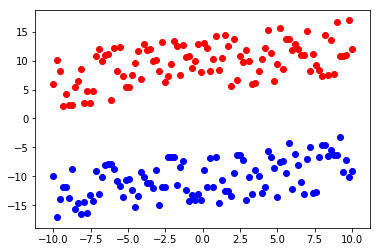

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

data_count = 100

x1_positive = np.linspace(-10, 10, data_count)
x2_positive = 0.3 * x1_positive + 10 + np.random.randint(-5, 5, data_count)
y_positive = np.array([1] * data_count)

x1_negative = np.linspace(-10, 10, data_count)
x2_negative = 0.3 * x1_negative - 10 + np.random.randint(-5, 5, data_count)
y_negative = np.array([-1] * data_count)

x1 = np.concatenate([x1_positive, x1_negative])
x2 = np.concatenate([x2_positive, x2_negative])

y_label = np.concatenate([y_positive, y_negative])

plt.scatter(x1_positive, x2_positive, c='r')
plt.scatter(x1_negative, x2_negative, c='b')
plt.show()

那么Linear Regression希望做什么呢，对于一个Linear Regression模型（函数）：

$$
y = \boldsymbol{w^Tx} + b
$$

直观地，Linear Regression希望最最小化下式：

$$
loss(\boldsymbol{w}, b) = \frac{1}{N}\sum^{N}_{i=0}(\boldsymbol{w^Tx_i} + b - y_i)^2
$$

这里使用平方损失函数其实问题很大，不过没关系，我们先忽略这点，稍后再来分析这里有什么问题。所以我们可以很自然的对$\boldsymbol{w}, b$求梯度：

$$
\begin{aligned}
        \frac{\partial loss(\boldsymbol{w}, b)}{\partial \boldsymbol{w}} &= \frac{2}{N}\sum^{N}_{i=0}(\boldsymbol{w^Tx_i} + b - y_i)\cdot \boldsymbol{x_i}, \\
        \frac{\partial loss(\boldsymbol{w}, b)}{\partial b} &= \frac{2}{N}\sum^{N}_{i=0}(\boldsymbol{w^Tx_i}+b-y_i)
\end{aligned}
$$

然后通过梯度下降更新$\boldsymbol{w}, b$：

$$
\begin{aligned}
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t - \eta \frac{\partial l(\boldsymbol{w}_t, b_t)}{\partial \boldsymbol{w}_t} \\
b_{t+1} &= b_t - \eta \frac{\partial l(\boldsymbol{w}_t, b_t)}{\partial b_t}
\end{aligned}
$$

然后通过几行代码简单实现一下：

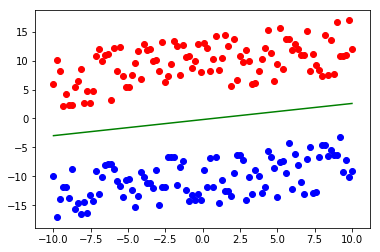

In [6]:
w1 = np.random.normal(0, 0.002)
w2 = np.random.normal(0, 0.002)
b = np.random.normal(0, 0.002)

training_steps = 1000

eta = 0.001

for step in range(training_steps):
    grad_w1 = np.mean((w1 * x1 + w2 * x2 + b - y_label) * x1)
    grad_w2 = np.mean((w1 * x1 + w2 * x2 + b - y_label) * x2)
    grad_b = np.mean(w1 * x1 + w2 * x2 + b)

    w1 -= eta * grad_w1
    w2 -= eta * grad_w2
    b -= eta * grad_b

plt.scatter(x1_positive, x2_positive, c='r')
plt.scatter(x1_negative, x2_negative, c='b')
plt.plot(x1, -(w1 * x1 + b) / w2, c='g')
plt.show()

## 梯度下降（Gradient Decent）

为什么能用梯度下降呢？这里快速预习一下泰勒公式：

$$
f(x) = \sum^{N}_{n=0}\frac{f^{(n)}(x_0)}{n!}(x - x_0)^n + R_n(x)
$$

泰勒公式的核心精神在于，某一个函数可以用该函数在某一点的函数值及其n阶导数值来近似表示，在我们的问题里，对于$\boldsymbol{w}$就有：

$$
loss(\boldsymbol{w}_{t+1}) = loss(\boldsymbol{w}_t + \Delta{\theta}) \approx loss(\boldsymbol{w}_t) + loss'(\boldsymbol{w}_{t})\Delta{\theta}
$$

如果希望梯度下降在本次迭代中使得损失函数值变小：

$$
loss(\boldsymbol{w}_{t+1}) -  loss(\boldsymbol{w}_{t}) = \nabla loss(\boldsymbol{w}_{t})\Delta{\theta} < 0
$$

通过观察可以发现，$\nabla loss(\boldsymbol{w}_{t})$与$\Delta{\theta}\ $都是二维向量，当$\Delta{\theta} = -\eta \nabla loss(\boldsymbol{w}_{t})$时，即两向量反向时，其内积有最小值。

## 平方损失函数的问题

理想情况下，初始化$\boldsymbol{w}, b$后，在误差反向传播计算梯度时，那些被错误分类的点，会带来很大误差，同时贡献可观的梯度用来更新权重。但是平方损失却不能很好的达到我们的目的。

最小化平方损失函数的目的在于对样本所有的数据点，通过调整$\ \boldsymbol{w}, b$，使他们的输出更靠近他们的标签，即-1或者1，而不是完美地解决我们的二分类问题，或者说，解决了二分类问题是最小化平方损失函数的一个顺带的结果。

同时，直觉地，一些被分类正确的点，反而会通过平方损失函数计算出极大的误差，贡献出可观的权重来修正自己，希望自己靠近标签，这是不合理的。

既然这个问题是平方损失函数带来的，那么理论上我们就应该通过重新设计损失函数解决这个问题。事实上，我们最原始的目标函数，或者损失函数，应该是：

$$
loss(\boldsymbol{w}, b) = \sum^{N}_{i=0}\delta \left( \boldsymbol{w^Tx_i} + b \ne y_i \right)
$$

但是这个损失函数是不可微的，也就没有办法用梯度下降的方式求解了。

## 合页损失函数（Hinge Loss）

事实上，带Sigmoid函数的交叉熵损失函数，或者带Sigmoid激活函数的平方损失函数也能解决这个问题，而前者一般叫Logistic Regression，而后者，好像还没有名字。在这里我们选用合页损失函数（Hingle Loss）：

$$
loss(\boldsymbol{w}, b) = \sum^{N}_{i=0} \max(0, 1 - y_i \cdot (\boldsymbol{w^Tx_i} + b))
$$

对于一维铰链损失函数，它的图像将会是：

直观地，我们可以看出，对于一个样本点，如果分类正确，那么$y_i$与$\boldsymbol{w^Tx_i} + b$应该同号，且如果他们的乘积大于1，那么损失函数的值为0，如果他们的乘积大于0（分类正确），小于1，那么损失函数的值就等于$1 - y_i \cdot (\boldsymbol{w^Tx_i} + b)$，而对于分类错误的情况，可以发现$y_i$与$\boldsymbol{w^Tx_i} + b$应该异号，则损失函数的值为$1 - y_i \cdot (\boldsymbol{w^Tx_i} + b)$。

不同于平方损失，我们可以发现，Hinge Loss在我们的二分类问题中更为合理，相对于平方损失函数“认为”模型对所有样本的预测结果都应该靠近标签，即-1或1而言（即与标签越相似越好），Hingle Loss则“认为”一些已经“显然”被分类正确的样本（$1 - y_i \cdot (\boldsymbol{w^Tx_i} + b) < 0$）显然地不应该传播误差，贡献梯度更新权重，即显然被分类正确的样本点不应该参与更新$\ \boldsymbol{w}, b$，因为他们的梯度为0。

而$0 < 1 - y_i \cdot (\boldsymbol{w^Tx_i} + b) < 1$，这些“险些”被分类错误的点，但是仍然被分类正确的点，被Hingle Loss“认为”分类还不够完美，仍然需要反向传播误差，贡献梯度更新权重。

而对于分类错误的点，它们的处理方法则与平方损失函数相同，直接反向传播误差贡献梯度更新权重即可。

从上我们还可以看出Hingle Loss的另外一个好处，即一些“显然”被分类正确点的不参与梯度计算，从而降低了一些计算的复杂度。

## 合页函数的梯度

而给定Hinge Loss的函数，则$\boldsymbol{w}$的梯度则有如下形式：

\begin{equation}  
\frac{\partial loss(\boldsymbol{w}, b)}{\partial \boldsymbol{w}} =
\left\{  
             \begin{array}
              \\-y_i \cdot \boldsymbol{x_i}, &  y_i \cdot (\boldsymbol{w^Tx_i} + b ) < 1\\  
              0, & y_i \cdot (\boldsymbol{w^Tx_i} + b ) > 1   
             \end{array}  
\right.  
\end{equation}

而对于$b$的梯度，则有如下形式：

\begin{equation}  
\frac{\partial loss(\boldsymbol{w}, b)}{\partial b} =
\left\{  
             \begin{array}
             \\-y_i, &  y_i \cdot (\boldsymbol{w^Tx_i} + b ) < 1\\  
             0, & y_i \cdot (\boldsymbol{w^Tx_i} + b ) > 1   
             \end{array}  
\right.  
\end{equation}

然后通过梯度下降更新$\boldsymbol{w}, b$：

$$
\begin{aligned}
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t - \eta \frac{\partial l(\boldsymbol{w}_t, b_t)}{\partial \boldsymbol{w}_t} \\
b_{t+1} &= b_t - \eta \frac{\partial l(\boldsymbol{w}_t, b_t)}{\partial b_t}
\end{aligned}
$$

通过几行代码简单实现一下：

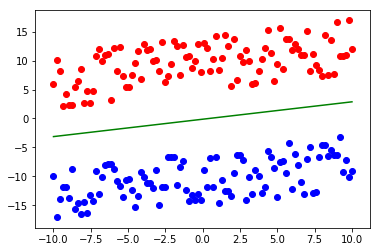

In [7]:
for step in range(training_steps):
    hinge_judge_term = y_label * (w1 * x1 + w2 * x2 + b)

    mask_no_grad = hinge_judge_term > 1

    grad_before_mean_w1 = -y_label * x1
    grad_before_mean_w1[mask_no_grad] = 0
    grad_w1 = np.mean(grad_before_mean_w1)

    grad_before_mean_w2 = -y_label * x2
    grad_before_mean_w2[mask_no_grad] = 0
    grad_w2 = np.mean(grad_before_mean_w2)

    grad_before_mean_b = -y_label * 1
    grad_before_mean_b[mask_no_grad] = 0
    grad_b = np.mean(grad_before_mean_b)

    w1 -= eta * grad_w1
    w2 -= eta * grad_w2
    b -= eta * grad_b

plt.scatter(x1_positive, x2_positive, c='r')
plt.scatter(x1_negative, x2_negative, c='b')
plt.plot(x1, -(w1 * x1 + b) / w2, c='g')
plt.show()

## 支持向量机（Support Vector Machine）

较为直观地，我们可以发现，随着梯度下降迭代的进行，渐渐地诸多样本点将不再反向传播误差，贡献梯度用来更新权重，因为他们已经“显然”被分类正确了，即$y_i \cdot (\boldsymbol{w^Tx_i} + b ) > 1 $，而那些直至迭代结束还在贡献梯度的样本点，将会被称之为支持向量，这也是支持向量机的来历。

其实到这里支持向量机就介绍完了。

有些观众朋友们可能就会问了，好像学过的支持向量机不是这么推导的呀，似乎应该是先写出最大化间隔，然后放缩，然后引出拉格朗日乘子法解等式约束的最值问题，然后引出KKT条件和不等式约束，然后构建广义拉格朗日方程使之与原始问题同解，然后领各种偏微分为0，解其对偶问题呢？

是这样的没错，上面一系列复杂的推导似乎是凸优化（虽然我没系统的学过）的一部分，这些内容将会在下一节预习，所以在这里先简要的说一下结论：

即如果我们为上面的Hinge Loss加上一个L2正则化项：

$$
loss(\boldsymbol{w}, b) = \sum^{N}_{i=0} \max(0, 1 - y_i \cdot (\boldsymbol{w^Tx_i} + b)) + \lambda \Vert \boldsymbol{w} \Vert ^2
$$

那么，通过这两种方法得到的结果本质上是相同的，为什么是相同的这里打算在下一节一起预习，所以这里先暂且结束了。

## 总结

这次主要从梯度下降的线性回归入手，从梯度下降和最小化Hinge Loss的角度预习了支持向量机，下一节将从传统凸优化的角度预习支持向量机。